# Coursera Capstone Project 
## Battle of Neighbourhoods
By Sohom Acharya, April 2021

### Analyse the boroughs and neighbourhoods of New York to select strategic locations to set up stores that supply authentic raw food materials for Indian restaurants in New York

**First we import all necessary libraries**

In [1]:
#Install and import libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

!pip install geopy
from geopy.geocoders import Nominatim
import urllib.request
import json
from urllib.request import urlopen
import requests
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
from sklearn.cluster import KMeans

!pip install folium
import folium

print('Libraries imported.')

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 94 kB 5.4 MB/s  eta 0:00:01
Libraries imported.


**Now, we download the New York data**

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Data downloaded!


**Load the json data to a dataframe**

In [3]:
neighborhoods_data = newyork_data['features']
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

**Lets view a sample of the data**

In [7]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [9]:
neighborhoods.tail()

,Borough,Neighborhood,Latitude,Longitude
301,Manhattan,Hudson Yards,40.756658,-74.000111
302,Queens,Hammels,40.587338,-73.805530
303,Queens,Bayswater,40.611322,-73.765968
304,Queens,Queensbridge,40.756091,-73.945631
305,Staten Island,Fox Hills,40.617311,-74.081740


**Getting the lattitude and longitude of New York**

In [10]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


**Dividing the whole data into five dataframes for the five boroughs**

In [13]:
neighborhoods_manhattan = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
neighborhoods_bronx = neighborhoods[neighborhoods['Borough'] == 'Bronx'].reset_index(drop=True)
neighborhoods_queens = neighborhoods[neighborhoods['Borough'] == 'Queens'].reset_index(drop=True)
neighborhoods_brooklyn = neighborhoods[neighborhoods['Borough'] == 'Brooklyn'].reset_index(drop=True)
neighborhoods_staten = neighborhoods[neighborhoods['Borough'] == 'Staten Island'].reset_index(drop=True)

**Setting up credentials for Foursquare API**

In [11]:
# The code was removed by Watson Studio for sharing.

**Creating function to get lattitude longitude data**

In [12]:

import urllib
def getNearbyVenues(names, latitudes, longitudes, radius=5000, categoryIds=''):
    try:
        venues_list=[]
        for name, lat, lng in zip(names, latitudes, longitudes):
            #print(name)

            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)

            if (categoryIds != ''):
                url = url + '&categoryId={}'
                url = url.format(categoryIds)

            # make the GET request
            response = requests.get(url).json()
            results = response["response"]['venues']

            # return only relevant information for each nearby venue
            for v in results:
                success = False
                try:
                    category = v['categories'][0]['name']
                    success = True
                except:
                    pass

                if success:
                    venues_list.append([(
                        name, 
                        lat, 
                        lng, 
                        v['name'], 
                        v['location']['lat'], 
                        v['location']['lng'],
                        v['categories'][0]['name']
                    )])

        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',  
                  'Venue Category']
    
    except:
        print(url)
        print(response)
        print(results)
        print(nearby_venues)

    return(nearby_venues)

**Creating Query to fetch results with category as "Indian restaurants" using the above function**

In [14]:
#For Manhattan
manhattan_ind = getNearbyVenues(names=neighborhoods_manhattan['Neighborhood'], latitudes=neighborhoods_manhattan['Latitude'],  longitudes=neighborhoods_manhattan['Longitude'],radius=1000, categoryIds='4bf58dd8d48988d10f941735')
manhattan_ind.shape

(1038, 7)

In [15]:
#For Bronx
bronx_ind = getNearbyVenues(names=neighborhoods_bronx['Neighborhood'], latitudes=neighborhoods_bronx['Latitude'],  longitudes=neighborhoods_bronx['Longitude'],radius=1000, categoryIds='4bf58dd8d48988d10f941735')
bronx_ind.shape

(59, 7)

In [17]:
#For Brooklyn
brooklyn_ind = getNearbyVenues(names=neighborhoods_brooklyn['Neighborhood'], latitudes=neighborhoods_brooklyn['Latitude'],  longitudes=neighborhoods_brooklyn['Longitude'],radius=1000, categoryIds='4bf58dd8d48988d10f941735')
brooklyn_ind.shape

(251, 7)

In [18]:
#For Queens
Queens_ind = getNearbyVenues(names=neighborhoods_queens['Neighborhood'], latitudes=neighborhoods_queens['Latitude'],  longitudes=neighborhoods_queens['Longitude'],radius=1000, categoryIds='4bf58dd8d48988d10f941735')
Queens_ind.shape

(405, 7)

In [19]:
#For Staten Island
staten_ind = getNearbyVenues(names=neighborhoods_staten['Neighborhood'], latitudes=neighborhoods_staten['Latitude'],  longitudes=neighborhoods_staten['Longitude'],radius=1000, categoryIds='4bf58dd8d48988d10f941735')
staten_ind.shape

(28, 7)

**Comapring the number of Indian restaurants in the five neighbourhoods**

In [20]:
print("Distribution of Indian Restaurants based on boroughs:")


table = {'Borough': ['Manhattan','Bronx','Queens','Brooklyn','Staten Island'],
        'Total Indian Restaurants': [manhattan_ind.shape[0],bronx_ind.shape[0],Queens_ind.shape[0],brooklyn_ind.shape[0],staten_ind.shape[0]]
        
        }
table_df = pd.DataFrame(table, columns= ['Borough','Total Indian Restaurants'])
table_df

Distribution of Indian Restaurants based on boroughs:


,Borough,Total Indian Restaurants
0,Manhattan,1038
1,Bronx,59
2,Queens,405
3,Brooklyn,251
4,Staten Island,28


**Analysing share of each neighborhood through a pie chart**

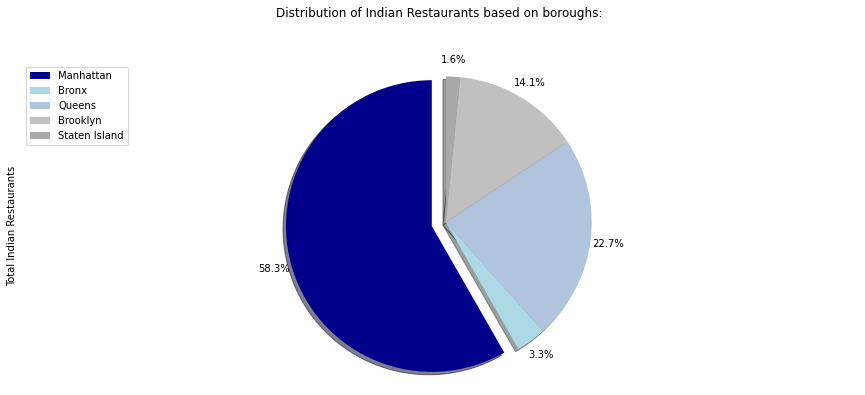

In [21]:
colors_list = ['darkblue', 'lightblue', 'lightsteelblue', 'silver', 'darkgrey']
explode_list = [0.1, 0, 0, 0, 0]

table_df['Total Indian Restaurants'].plot(kind='pie',
                            figsize=(15, 6),
                            autopct='%1.1f%%',
                            startangle=90,
                            shadow=True,
                            labels=None,         
                            pctdistance=1.12,    
                            colors=colors_list,  
                            explode=explode_list 
                            )

# scale the title up by 12% to match pctdistance
plt.title('Distribution of Indian Restaurants based on boroughs:', y=1.12)

plt.axis('equal')

# add legend
plt.legend(labels=table_df.Borough, loc='upper left')

plt.show()

**As we can see, Manhattan takes up more than fift percent of the data, so we will work on Manhattan borough**

**We will now analyse the neighbourhoods of Manhattan**

In [22]:
#Listing the total Indian restaurants by neighbourhood in Manhattan
manhattan_grouped = manhattan_ind.groupby('Neighborhood').count().reset_index()

manhattan_grouped_out = manhattan_grouped.rename(columns={'Venue': 'Total Indian Restaurants'})
manhattan_grouped_out.drop(['Neighborhood Latitude','Neighborhood Longitude','Venue Latitude','Venue Longitude','Venue Category'], inplace = True, axis = 1)
manhattan_grouped_out

,Neighborhood,Total Indian Restaurants
0,Battery Park City,24
1,Carnegie Hill,12
2,Central Harlem,10
3,Chelsea,17
4,Chinatown,23
5,Civic Center,27
6,Clinton,41
7,East Harlem,7
8,East Village,48
9,Financial District,26


<function matplotlib.pyplot.show(*args, **kw)>

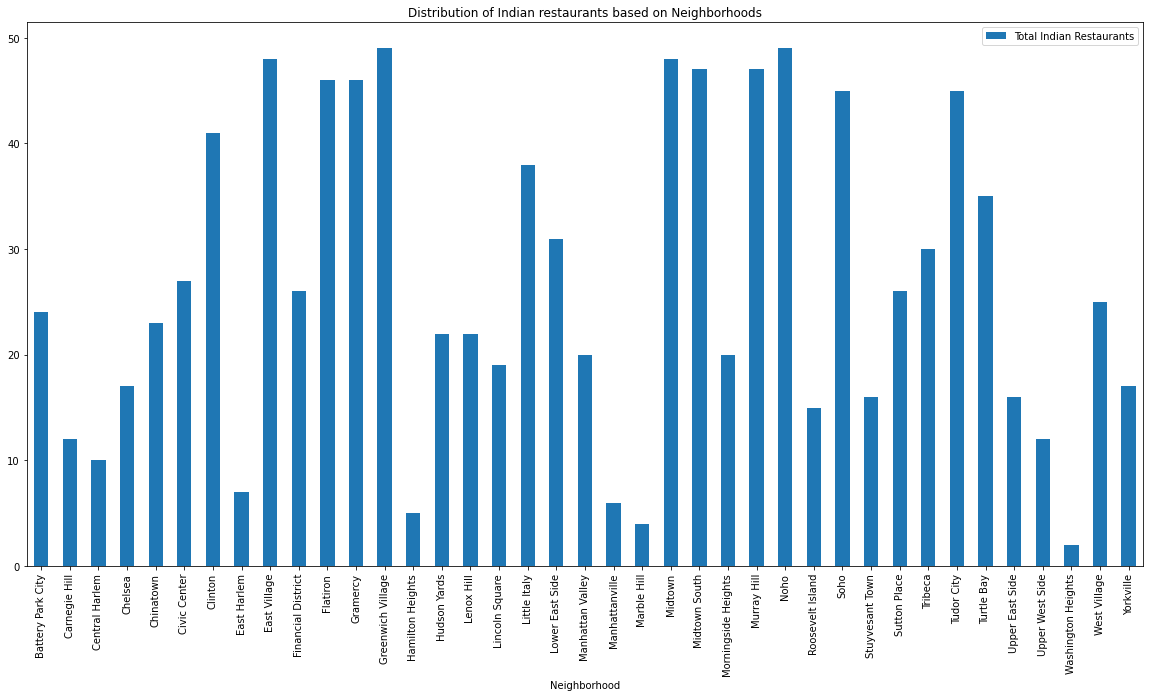

<Figure size 7200x7200 with 0 Axes>

In [23]:
#Visualising it in a bar graph
import matplotlib.pyplot as plot
manhattan_grouped_out.plot.bar(x="Neighborhood", y="Total Indian Restaurants", title="Distribution of Indian restaurants based on Neighborhoods",figsize=(20,10))
plot.figure(figsize=(100,100))
plot.show

In [24]:
#Finding the top five neighbourhoods of Manhattan with respect to total Indian restaurants count
manhattan_grouped_out.sort_values(by=['Total Indian Restaurants'], inplace=True,ascending=False)
manhattan_grouped_out.head()

,Neighborhood,Total Indian Restaurants
12,Greenwich Village,49
26,Noho,49
8,East Village,48
22,Midtown,48
25,Murray Hill,47


In [32]:
#Plotting the map of Indian restaurants in Manhattan
import folium
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, venue, neighborhood in zip(manhattan_ind['Venue Latitude'], manhattan_ind['Venue Longitude'], manhattan_ind['Venue'], manhattan_ind['Neighborhood']):
    label = '{}, {}'.format(neighborhood, venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

In [28]:
#Using the above map to generate a heat map of Indian restaurants in Manhattan
from folium import plugins

manhattan_data = manhattan_ind[["Venue Latitude", "Venue Longitude"]].to_numpy().tolist()

map_manhattan.add_child(plugins.HeatMap(manhattan_data))

**With this, we have analysed the location of Indian Restauarants based on both count and heat maps**

**The analysis will be available in the report of this project.
Thank you**